# Historical Validation

Using CERF allocation, people affected and testing out Scenarios 2 and 3.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import LineString
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [3]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")

In [4]:
cerf_emdat_df = pd.read_csv(
    Path(AA_DATA_DIR) / "public/exploration/mdg/cerf_emdat_bngrc_data.csv"
)

In [5]:
cerf_emdat_df[cerf_emdat_df["Nom"] == "BATSIRAI"]

,Nom,Total Affected - EMDAT,Sinistres,CERF Allocations
56,BATSIRAI,112115.0,166671.0,4476918.0


In [6]:
# load ibtracs
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)
# Combining US Wind and Reunion wind for those with no wind speed data
gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * 0.88
)

In [7]:
gdf_points[gdf_points["NAME"] == "EMNATI"]["REU_WIND"].unique()

array([nan])

In [8]:
gdf_points[gdf_points["NAME"] == "BATSIRAI"]["REU_WIND"].unique()

array([nan])

In [9]:
adm0_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)

In [10]:
# Create buffer around gdf_adm0 with the given distance
# Reproject to a CRS that uses meters (e.g., EPSG:3857)
gdf_adm0_buffer = gdf_adm0.to_crs(epsg=3857)

# Apply the buffer of 100 km (100,000 meters)
gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
    100 * 1000
)  # 100 km = 100,000 meters

# Reproject back to the original CRS
gdf_adm0_buffer = gdf_adm0_buffer.to_crs(gdf_adm0.crs)

In [11]:
gdf_points_sel = gpd.sjoin(
    gdf_points, gdf_adm0_buffer, how="inner", predicate="intersects"
)
gdf_points_sel_ = gdf_points_sel.sort_values("ISO_TIME")
gdf_points_sel_2006 = gdf_points_sel_[gdf_points_sel_["year"] >= 2006]

Text(0.5, 1.0, 'IBTrACS with a 100km buffer around MDG')

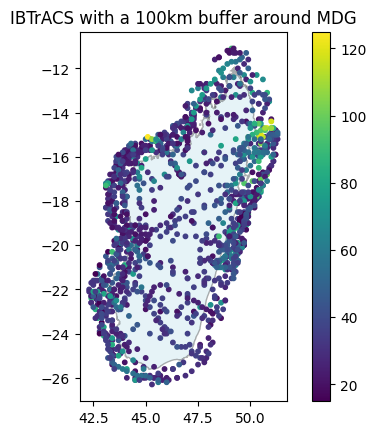

In [12]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)
ax.set_title("IBTrACS with a 100km buffer around MDG")

In [13]:
cyclones_since_2006 = gdf_points_sel_2006[
    gdf_points_sel_2006["REU_WIND"] >= 48
]["NAME"].unique()

In [14]:
# which storms are met for Scenario 2 and 3
scenario2_storms = gdf_points_sel_2006[gdf_points_sel_2006["REU_WIND"] >= 64][
    "NAME"
].unique()
scenario3_storms = gdf_points_sel_2006[gdf_points_sel_2006["REU_WIND"] >= 90][
    "NAME"
].unique()

In [15]:
cerf_emdat_df.columns

Index(['Nom', 'Total Affected - EMDAT', 'Sinistres', 'CERF Allocations'], dtype='object')

In [28]:
gdf_points_sel_2006.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'hour', 'min', 'geometry', 'REU_USA_WIND', 'index_right', 'ADM0_PCODE',
       'ADM0_EN', 'SOURCE', 'Year', 'Season'],
      dtype='object', length=187)

In [26]:
# Adding year and season into df for output later
gdf_points_sel_2006.loc[:, "Year"] = gdf_points_sel_2006["SEASON"]
gdf_points_sel_2006.loc[:, "Season"] = gdf_points_sel_2006.apply(
    lambda x: (
        f"{x['year'] - 1}-{x['year']}"
        if x["month"] < 6
        else f"{x['year']}-{x['year'] + 1}"
    ),
    axis=1,
)

In [33]:
# adding year and season to output
cerf_emdat_df = cerf_emdat_df.merge(
    gdf_points_sel_2006[["NAME", "Year", "Season"]].drop_duplicates(),
    left_on="Nom",
    right_on="NAME",
    how="left",
)

In [34]:
cerf_emdat_df = cerf_emdat_df[cerf_emdat_df["Nom"].isin(cyclones_since_2006)]

In [35]:
cerf_emdat_df["Scenario 2"] = [
    storm in scenario2_storms for storm in cerf_emdat_df["Nom"]
]
cerf_emdat_df["Scenario 3"] = [
    storm in scenario3_storms for storm in cerf_emdat_df["Nom"]
]

df = cerf_emdat_df[
    [
        "Nom",
        "Season",
        "Scenario 2",
        "Scenario 3",
        "Total Affected - EMDAT",
        "Sinistres",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected - EMDAT", ascending=False)


# Define functions for highlighting and coloring bars
def highlight_true(val):
    color = "red" if val else ""
    return f"background-color: {color}"


def color_bar_affected(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, orange {val/df_sorted["Total Affected - EMDAT"].max()*100}%, transparent {val/df_sorted["Total Affected - EMDAT"].max()*100}%);'
    return ""


def color_bar_sinistres(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, #FFD700 {val/df_sorted["Sinistres"].max()*100}%, transparent {val/df_sorted["Sinistres"].max()*100}%);'
    return ""


def color_bar_cerf(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, green {val/df_sorted["CERF Allocations"].max()*100}%, transparent {val/df_sorted["CERF Allocations"].max()*100}%);'
    return ""


# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Scenario 2",
            "Scenario 3",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected - EMDAT"])
    .map(color_bar_sinistres, subset=["Sinistres"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "Total Affected - EMDAT": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "Sinistres": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

# Display the styled DataFrame
styled_df

,Nom,Season,Scenario 2,Scenario 3,Total Affected - EMDAT,Sinistres,CERF Allocations
6,IVAN,2007-2008,True,True,"524,153","487,146","4,625,583"
18,ENAWO,2016-2017,True,True,"434,253","437,443","4,999,601"
13,GIOVANNA,2011-2012,True,False,"250,284","247,014","1,999,893"
3,INDLALA,2006-2007,True,True,"215,198","1,740,911","1,230,903"
10,HUBERT,2009-2010,False,False,"192,132",,
17,CHEDZA,2014-2015,False,False,"174,007",,
19,AVA,2017-2018,True,False,"161,318","161,328",
12,BINGIZA,2010-2011,True,False,"115,215","267,099",
14,IRINA,2011-2012,False,False,"85,015",,
9,JADE,2008-2009,False,False,"64,918","60,818",
